The risk-neutral valuation formula for a European option is given by,
$$V\left(x,t_0\right) = exp\left(-r \Delta t\right) \int_{\mathbb{R}} V\left(y,T\right) f\left(y|x\right) dy $$

We discretize the support over a finite range
$$V\left(x,t_0\right) = exp\left(-r \Delta t\right) \int_{[a,b]} V\left(y,T\right) f\left(y|x\right) dy $$

The Cosine Approximation states that:
$$\mathcal{Real}\left\{ \hat{\phi}_x \left( \frac{k \pi}{b-a}\right) \cdot exp\left( -i \frac{k a \pi}{b-a} \right) \right\} = \int_{a}^{b} f_x\left(y\right) cos\left( k \pi \frac{y-a}{b-a} \right)$$

Replacing the density by the Cos approximation and replacing the integration into a summation results in:
$$\hat{V} \left(x,t_0\right) - exp\left(-r \Delta t\right) \left( \sum_{n=0}^{N-1} \right)^\prime \mathcal{Real} \left( \phi \left( \frac{n \pi}{b-a};x\right) exp \left(-i n \pi \frac{a}{b-a} \right) \right) H_n$$

Here,
$$H_{k}^{call} = \frac{2}{b-a} K( \chi_k(0,b) - \psi_k(0,b) )$$

$$H_{k}^{put} = \frac{2}{b-a} K( -\chi_k(0,b) + \psi_k(0,b) )$$

where,
$$
\begin{aligned}
\chi_k(c, d): & =\frac{1}{1+\left(\frac{k \pi}{b-a}\right)^2}\left[\cos \left(k \pi \frac{d-a}{b-a}\right) \mathrm{e}^d-\cos \left(k \pi \frac{c-a}{b-a}\right) \mathrm{e}^c\right. \\
& \left.+\frac{k \pi}{b-a} \sin \left(k \pi \frac{d-a}{b-a}\right) \mathrm{e}^d-\frac{k \pi}{b-a} \sin \left(k \pi \frac{c-a}{b-a}\right) \mathrm{e}^c\right],
\end{aligned}
$$
and
$$
\psi_k(c, d):= \begin{cases}{\left[\sin \left(k \pi \frac{d-a}{b-a}\right)-\sin \left(k \pi \frac{c-a}{b-a}\right)\right] \frac{b-a}{k \pi},} & k \neq 0, \\ (d-c), & k=0 .\end{cases}
$$

It took 0.00037975788116455077 seconds to price.
Abs error for strike 80.0 is equal to 1.31E-07
Abs error for strike 90.0 is equal to 3.93E-07
Abs error for strike 100.0 is equal to 3.87E-07
Abs error for strike 110 is equal to 4.32E-07
Abs error for strike 120.0 is equal to 3.50E-07


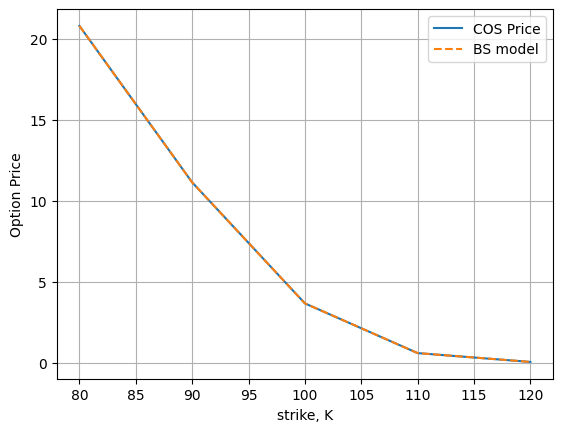

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time

def CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)  
        
    # reshape K to a column vector
    K = np.array(K).reshape([len(K),1])
    
    #assigning i=sqrt(-1)
    i = complex(0.0,1.0) 
    
    x0 = np.log(S0 / K)   
    
    # truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # sumation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a);  

    # Determine coefficients for Put Prices  
    H_k = CallPutCoefficients(CP,a,b,k)
       
    mat = np.exp(i * np.outer((x0 - a) , u))

    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    
    value = np.exp(-r * tau) * K * np.real(mat.dot(temp))
         
    return value

""" 
Determine coefficients for Put Prices 
"""
def CallPutCoefficients(CP,a,b,k):
    if str(CP).lower()=="c" or str(CP).lower()=="1":                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
        
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    

def BS_Call_Option_Price(CP,S_0,K,sigma,tau,r):
    #Black-Scholes Call option price
    cp = str(CP).lower()
    K = np.array(K).reshape([len(K),1])
    d1    = (np.log(S_0 / K) + (r + 0.5 * np.power(sigma,2.0)) 
    * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if cp == "c" or cp == "1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif cp == "p" or cp =="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value

def mainCalculation():
    i = complex(0.0,1.0)
    
    CP = "c"
    S0 = 100.0
    r = 0.1
    tau = 0.1
    sigma = 0.25
    K = [80.0, 90.0, 100.0, 110, 120.0]
    N = 4*32
    L = 10
    
    # Definition of the characteristic function for the GBM, this is an input
    # for the COS method
    # Note that Chf does not include coefficient "+iuX(t_0)" this coefficient
    # is included internally in the evaluation
    # In the book we denote this function as \varphi(u)

    cf = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * tau - 0.5 
                          * np.power(sigma, 2.0) * np.power(u, 2.0) * tau)
    
    # Timing results 
    NoOfIterations = 100
    time_start = time.time() 
    for k in range(0,NoOfIterations,1):
        val_COS = CallPutOptionPriceCOSMthd(cf,CP,S0,r,tau,K,N,L)
    time_stop = time.time()
    print("It took {0} seconds to price.".format((time_stop-time_start)/float(NoOfIterations)))
    
    # evaluate analytical Black Scholes equation
    val_Exact = BS_Call_Option_Price(CP,S0,K,sigma,tau,r)
    plt.plot(K,val_COS)
    plt.plot(K,val_Exact,'--')
    plt.xlabel("strike, K")
    plt.ylabel("Option Price")
    plt.legend(["COS Price","BS model"])
    plt.grid()    
    
    #Error comuputation
    error = []
    for i in range(0,len(K)):
        error.append(np.abs(val_COS[i]-val_Exact[i])[0])
        print("Abs error for strike {0} is equal to {1:.2E}".format(K[i],error[i]))
        
mainCalculation()